In [42]:
import numpy as np
from scipy import signal

def resample_emg(single_emg, target_length=1000):
    """
    Resamples EMG signal to a fixed number of time points (target_length).
    Assumes input shape is (8, N), returns shape (8, target_length).
    """
    # Get the current length along axis 1
    current_length = single_emg.shape[1]
    
    # Resample with proper up/down parameters
    return signal.resample_poly(single_emg, target_length, current_length, axis=1)


# Getting EMG data from the JSON files

In [ ]:
import os
import json
import numpy as np

def load_custom_emg_data(dataset_path, max_users=50):
    all_emg_data = []
    labels = []

    for main_folder in ['trainingJSON']:
        folder_path = os.path.join(dataset_path, main_folder)

        user_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
        user_folders = user_folders[:max_users]  # Limit to the first `max_users` folders

        for user_folder in user_folders:
            user_path = os.path.join(folder_path, user_folder)

            for file in os.listdir(user_path):
                if file.endswith('.json'):
                    json_path = os.path.join(user_path, file)
                    with open(json_path, 'r') as f:
                        data = json.load(f)

                    samples = data.get("trainingSamples", {})
                    for sample in samples.values():
                        gesture_name = sample.get("gestureName", "unknown")
                        emg = sample.get("emg", {})

                        ch_values = [emg.get(f"ch{i+1}", []) for i in range(8)]
                        if all(len(ch) == len(ch_values[0]) for ch in ch_values):  # sanity check
                            if len(ch_values[0]) >= 900:  # assuming your nyquist constraint
                                emg_matrix = np.array(ch_values)
                                resampled_matrix = resample_emg(emg_matrix)
                                all_emg_data.append(resampled_matrix)
                                labels.append(gesture_name)

    return all_emg_data, labels

# Example usage:
dataset_path = '/home/codebaker/Desktop/EMG-EPN612 Dataset'
emg_data, gesture_labels = load_custom_emg_data(dataset_path, max_users=50)

print(f"Loaded {len(emg_data)} gestures")
print(f"Unique gestures: {set(gesture_labels)}")

if emg_data:
    print(f"Sample shape: {emg_data[0].shape}")


Loaded 7500 gestures
Unique gestures: {'pinch', 'noGesture', 'fist', 'waveIn', 'waveOut', 'open'}
Sample shape: (8, 1000)


In [45]:
np.save('../train_data/train_emg_data.npy', emg_data)


# Preprocess EMG: Bandpass filtering (20-450 Hz), and normalization (min-max)

In [ ]:
import numpy as np
from scipy import signal

emg_data = np.load("../train_data/train_emg_data.npy")
def preprocess_emg(single_np_emg, sampling_rate):
    """
    emg_data shape: (8, N) where 8 = number of channels, N = time points
    """
    # Bandpass filter between 20-450 Hz
    lowcut = 20.0
    highcut = 450.0
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(4, [low, high], btype='band')

    # Transpose to (N, 8) for filtering along axis=0 (time axis)
    emg_data_t = single_np_emg.T  # shape becomes (N, 8)
    filtered_emg = signal.filtfilt(b, a, emg_data_t, axis=0)

    # Normalize the data (min-max normalization)
    normalized_emg = (filtered_emg - np.min(filtered_emg, axis=0)) / (np.max(filtered_emg, axis=0) - np.min(filtered_emg, axis=0) + 1e-8)

    return normalized_emg.T  # Return shape back to (8, N)

def preprocess_all_emg_data(emg_data):
    preprocessed_data = []
    for single_emg in emg_data:
        # Preprocess each sample (8 channels, N time points)
        preprocessed_sample = np.array(preprocess_emg(single_emg, 1000))
        preprocessed_data.append(preprocessed_sample)

    return preprocessed_data

preprocessed_emg = np.array(preprocess_all_emg_data(emg_data))
print(len(preprocessed_emg))


7500


In [ ]:
gesture_to_id = {
    "noGesture": 0,       # Example: fist = 0
    "fist": 1,       # open = 1
    "open": 2,      # pinch = 2
    "waveIn": 3,    # wave_in = 3
    "pinch": 4,   # wave_out = 4
    "waveOut": 5  # no_gesture = 5
}
# Convert gesture names to numerical IDs
label_ids = [gesture_to_id[name] for name in gesture_labels]

# Verify
print("First 150 labels:", label_ids[:150])


In [47]:
np.save('../train_data/train_processed.npy', preprocessed_emg)

In [ ]:
print(emg_data[0].shape)
print(preprocessed_emg[0].shape)
print(emg_data[0][:, -5:])
print(preprocessed_emg[0][:, -5:])

(8, 1000)
(8, 1000)
[[ 9.62840604e-01 -2.02054839e+00 -9.91972009e-01 -3.02662306e+00
  -2.98931084e+00]
 [-1.98304296e+00 -1.00590346e+00 -2.00310951e+00 -9.93557847e-01
  -1.00029936e+00]
 [-3.95992390e-02 -3.01743723e+00 -1.99876188e+00 -2.99817241e+00
   1.15999208e-02]
 [-3.03333533e+00 -1.96877897e+00 -9.94291527e-01  7.35081586e-03
  -1.84522428e-03]
 [-1.99922825e+00 -2.00370657e+00 -9.75984738e-01 -5.90142068e-03
  -1.00083429e+00]
 [-9.76779514e-01  1.00610342e+00 -4.47206249e-04  9.98757980e-01
  -1.00638070e+00]
 [-9.80772141e-01 -1.01123216e+00 -9.86710726e-01 -2.39204865e-03
  -1.00176954e+00]
 [ 1.05744728e+00  9.44740941e-01 -2.00480379e+00 -1.00040786e+00
  -2.00115662e+00]]
[[0.85863433 0.53130074 0.67109546 0.45587136 0.48387956]
 [0.40275419 0.55643848 0.40483607 0.55498748 0.55648223]
 [0.48933501 0.269082   0.27747435 0.22008784 0.5281119 ]
 [0.09527757 0.18810379 0.35357186 0.46127729 0.45821443]
 [0.20880491 0.28176702 0.38000481 0.56174778 0.41296392]
 [0.56178

# Visualising EMG-Raw and PreProcessed Signal for 8 channels of emg_data[0]

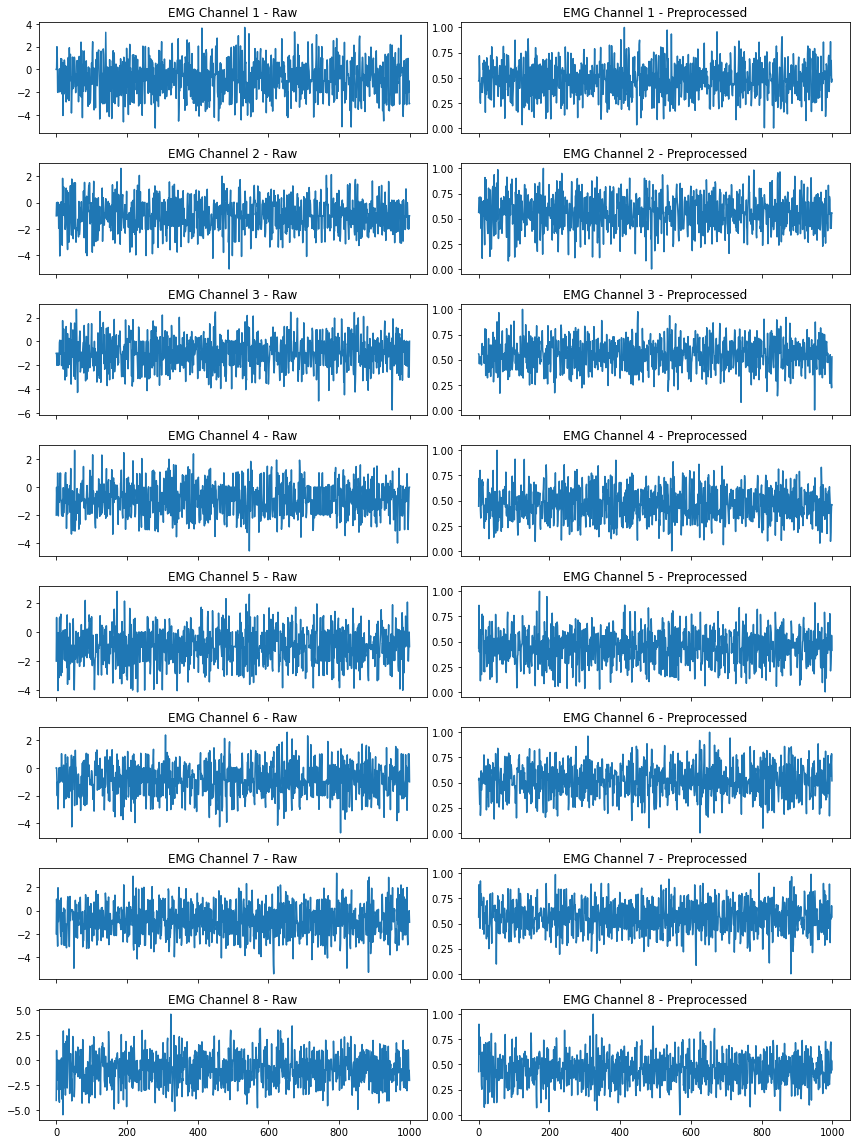

In [48]:

import matplotlib.pyplot as plt

def plot_emg_signals(raw_emg, preprocessed_emg, title_prefix="EMG Channel"):
    channels = raw_emg.shape[0]
    time_points = raw_emg.shape[1]
    time = np.arange(time_points)

    fig, axs = plt.subplots(channels, 2, figsize=(12, 2 * channels), sharex=True)

    for i in range(channels):
        axs[i, 0].plot(time, raw_emg[i])
        axs[i, 0].set_title(f"{title_prefix} {i+1} - Raw")

        axs[i, 1].plot(time, preprocessed_emg[i])
        axs[i, 1].set_title(f"{title_prefix} {i+1} - Preprocessed")

    plt.tight_layout()
    plt.show()

plot_emg_signals(emg_data[0], preprocessed_emg[0])

# Finding EWT for the 8 channels, and for each channel 5 IMFs

In [1]:
import numpy as np
from scipy.signal import find_peaks, resample
from scipy.fft import fft, fftfreq

preprocessed_emg = np.load("../train_data/train_processed.npy")
def empirical_wavelet_transform(signal, fs=1000, n_imfs=7, target_length=1000):
    """
    Perform EWT on a 1D signal and resample IMFs to the same length.
    Args:
        signal: 1D array (time series)
        fs: Sampling frequency (Hz)
        n_imfs: Number of IMFs to extract
        target_length: Length to which each IMF should be resampled
    Returns:
        List of resampled IMFs (high to low frequency)
    """
    n = len(signal)
    fft_vals = fft(signal)
    freqs = fftfreq(n, 1/fs)
    
    pos_freq = freqs[freqs > 0]
    pos_fft = np.abs(fft_vals[freqs > 0])
    
    peaks, _ = find_peaks(pos_fft, height=np.mean(pos_fft), distance=50)
    if len(peaks) < 2:
        peaks = np.array([0, len(pos_freq)//2, len(pos_freq)-1])
    
    boundaries = np.sort(pos_freq[peaks])
    if len(boundaries) > n_imfs + 1:
        boundaries = boundaries[:n_imfs + 1]
    
    if boundaries[0] > 0:
        boundaries = np.insert(boundaries, 0, 0)
    if boundaries[-1] < fs/2:
        boundaries = np.append(boundaries, fs/2)
    
    imfs = []
    for i in range(len(boundaries)-1, 0, -1):
        low, high = boundaries[i-1], boundaries[i]
        mask = ((np.abs(freqs) >= low) & (np.abs(freqs) < high))
        filtered_fft = fft_vals.copy()
        filtered_fft[~mask] = 0
        imf = np.real(np.fft.ifft(filtered_fft))
        
        # Resample IMF to target length
        imf_resampled = resample(imf, target_length)
        imfs.append(imf_resampled)
    
    # Ensure we always return exactly n_imfs components
    while len(imfs) < n_imfs:
        imfs.append(np.zeros(target_length))  # Pad with zeros if not enough IMFs
    imfs = imfs[:n_imfs]  # Truncate if too many IMFs
    
    return imfs

# --- Parameters ---
fs = 1000
n_imfs = 7
target_length = 1000

# --- Process all gestures and channels ---
all_imfs = []

for gesture in preprocessed_emg:
    gesture_imfs = []
    for channel in range(8):
        signal = gesture[channel]
        imfs = empirical_wavelet_transform(signal, fs=fs, n_imfs=n_imfs, target_length=target_length)
        gesture_imfs.append(imfs[1:5])
    all_imfs.append(gesture_imfs)

# Convert to numpy array with proper shape
try:
    all_imfs = np.array(all_imfs)
    print("Final IMFs shape:", all_imfs.shape)  
except ValueError as e:
    print(f"Error creating array: {e}")
    print("Checking shapes...")
    
    # Print shapes for debugging
    for i, gesture in enumerate(all_imfs):
        for j, channel in enumerate(gesture):
            print(f"Gesture {i}, Channel {j}: {[imf.shape for imf in channel]}")

Final IMFs shape: (7500, 8, 4, 1000)


In [2]:
np.save("../train_data/train_imfs.npy", all_imfs)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import resample
from scipy.fft import fft, fftfreq

preprocessed_emg = np.load("../train_data/train_processed.npy")
all_imfs = np.load("../train_data/train_imfs.npy")
def plot_time_domain(signal, imfs, fs=1000, channel_idx=None):
    """Plot original signal and its IMFs in time domain"""
    original_length = len(signal)
    time = np.arange(original_length) / fs  # Time axis based on original signal
    
    plt.figure(figsize=(12, 2 * (len(imfs) + 1)))
    
    # Plot original signal
    plt.subplot(len(imfs) + 1, 1, 1)
    plt.plot(time, signal, 'b')
    title = 'Original EMG' + (f' (Channel {channel_idx + 1})' if channel_idx is not None else '')
    plt.title(title)
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # Plot IMFs (resampled to match original signal length)
    for i, imf in enumerate(imfs):
        imf_resampled = resample(imf, original_length)
        plt.subplot(len(imfs) + 1, 1, i + 2)
        plt.plot(time, imf_resampled, 'r')
        plt.title(f'IMF {i + 1}')
        plt.ylabel('Amplitude')
        plt.grid(True)
    
    plt.xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

def plot_frequency_domain(signal, imfs, fs=1000):
    """Plot frequency spectra of signal and IMFs"""
    original_length = len(signal)
    freqs = fftfreq(original_length, 1 / fs)[:original_length // 2]
    
    plt.figure(figsize=(12, 2 * (len(imfs) + 1)))
    
    # Original signal spectrum
    plt.subplot(len(imfs) + 1, 1, 1)
    plt.plot(freqs, 2.0 / original_length * np.abs(fft(signal)[:original_length // 2]))
    plt.title('Original Signal Spectrum')
    plt.ylabel('Magnitude')
    plt.grid(True)
    
    # IMFs spectra (resampled to match original signal length)
    for i, imf in enumerate(imfs):
        imf_resampled = resample(imf, original_length)
        spectrum = 2.0 / original_length * np.abs(fft(imf_resampled)[:original_length // 2])
        plt.subplot(len(imfs) + 1, 1, i + 2)
        plt.plot(freqs, spectrum)
        plt.title(f'IMF {i + 2} Spectrum')
        plt.ylabel('Magnitude')
        plt.grid(True)
    
    plt.xlabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

# ✅ Example usage assuming:
# all_preprocessed: shape [sample][channel][time]
# all_imfs: shape [sample][channel][imf][time]

sample_idx = 0  # You can loop through more if needed
print("Shape of all_imfs:", all_imfs.shape)

for channel_idx in range(preprocessed_emg[sample_idx].shape[0]):
    signal = preprocessed_emg[sample_idx][channel_idx]
    imfs = all_imfs[sample_idx][channel_idx]

    plot_time_domain(signal, imfs, channel_idx=channel_idx)
    plot_frequency_domain(signal, imfs)

In [ ]:
import numpy as np
from scipy.stats import entropy, skew, kurtosis

# Feature extraction from a single IMF signal
all_imfs = np.load("../train_data/train_imfs.npy")
def extract_features_from_imf_segment(imf_segment):
    """Extract features from one segment of the IMF signal."""
    return [
        np.mean(imf_segment),
        np.max(imf_segment),
        np.min(imf_segment),
        np.std(imf_segment),
        skew(imf_segment),
        kurtosis(imf_segment)
    ]

# Feature matrix builder for shape: (samples, channels, imfs, points)
def build_feature_matrix(ewt_matrix):
    feature_matrix = []

    n_samples, n_channels, n_imfs, n_points = ewt_matrix.shape
    num_segments = 9  # Dividing the signal into 9 segments

    # Length of each segment
    segment_length = n_points // num_segments

    for sample_idx in range(n_samples):
        features = []

        for ch in range(n_channels):
            for imf in range(n_imfs):
                imf_signal = ewt_matrix[sample_idx, ch, imf, :]

                # Split the signal into 9 segments
                segments = [imf_signal[i * segment_length : (i + 1) * segment_length] for i in range(num_segments)]

                # For each segment, extract features and form a 3x3 matrix
                segment_features = []
                for segment in segments:
                    segment_features.extend(extract_features_from_imf_segment(segment))

                features.extend(segment_features)  # Add features for this IMF and channel

        feature_matrix.append(features)


    return np.array(feature_matrix)

# ✅ Run the code
feature_matrix = build_feature_matrix(all_imfs)

# 🖨️ Output shapes
print("✅ Feature matrix shape:", feature_matrix.shape)  # Example: (3000, 320)
# Optional preview
print("\nSample features (first row):\n", feature_matrix[0][:16], "...")


✅ Feature matrix shape: (7500, 1728)
✅ Labels shape: (7500,)

Sample features (first row):
 [ 4.75738205e-04  1.79186963e-01 -1.66610357e-01  7.12790548e-02
  2.20688009e-02 -3.98946898e-01  2.27269109e-04  2.11877155e-01
 -2.32855682e-01  8.71911930e-02  1.63773806e-04 -5.07898358e-01
 -5.86353072e-04  1.62774557e-01 -1.56881813e-01  6.91365322e-02] ...


# This is for another feature extraction

In [ ]:
import numpy as np
from scipy.stats import entropy
from scipy.signal import hilbert, welch

def extract_discriminatory_imf_features(imf_segment):
    """Extract only features proven most discriminatory for gesture recognition"""
    features = []
    
    # 1. Energy-Based Features (most important)
    rms = np.sqrt(np.mean(imf_segment**2))
    features.append(rms)
    
    # 2. Frequency-Domain Dominance
    f, psd = welch(imf_segment, fs=1000)  # Adjust fs to your sampling rate
    dominant_freq = f[np.argmax(psd)]
    features.append(dominant_freq)
    
    # 3. Nonlinear Complexity
    analytic_signal = hilbert(imf_segment)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    phase_entropy = entropy(np.histogram(instantaneous_phase, bins=10)[0])
    features.append(phase_entropy)
    
    # 4. Zero-Crossing Variability
    zcr = len(np.where(np.diff(np.sign(imf_segment)))[0]) / len(imf_segment)
    features.append(zcr)
    
    return np.array(features)

def build_discriminatory_feature_matrix(imf_matrix):
    """Build matrix using only discriminatory features"""
    n_samples, n_channels, n_imfs, _ = imf_matrix.shape
    features_per_imf = 4  # The 4 discriminatory features above
    
    feature_matrix = np.empty((n_samples, n_channels * n_imfs * features_per_imf))
    
    for sample_idx in range(n_samples):
        sample_features = []
        
        for ch in range(n_channels):
            for imf in range(n_imfs):
                imf_data = imf_matrix[sample_idx, ch, imf, :]
                sample_features.extend(extract_discriminatory_imf_features(imf_data))
        
        feature_matrix[sample_idx] = sample_features
        
    
    return feature_matrix

In [ ]:
feature_matrix = build_discriminatory_feature_matrix(all_imfs)


In [ ]:
print(all_imfs.shape)
print("Sample labels (first 10):", gesture_labels[120])
feature_matrix.shape

(7500, 8, 4, 1000)
Sample labels (first 10): (7500,)


(7500, 128)

In [ ]:
np.save('../train_data/train_feature_matrix.npy', feature_matrix)
np.save('../train_data/train_gesture_labels.npy', labels)
